In [34]:
import pandas as pd
import numpy as np

In [56]:
flats_df = pd.read_csv("SPb/SPb_addr_area_price_lon_lat.csv", sep=",")

In [57]:
flats_df.head()

,address,area,price,longtitude,latitude
0,"Санкт-Петербург, ул. Вадима Шефнера, 10к1",65.0,192308,59.938658,30.205582
1,"Санкт-Петербург, ул. Салова, д. 61, лит. А",37.0,146723,59.885142,30.368554
2,"Санкт-Петербург, ул. Плесецкая, д. 20, корп. 1",24.3,127572,60.039076,30.227959
3,"Санкт-Петербург, Пулковское ш., 38к7",26.8,166045,59.820553,30.327591
4,"Санкт-Петербург, ул. Вадима Шефнера, д. 4",28.0,127709,59.934695,30.208681


In [58]:
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt

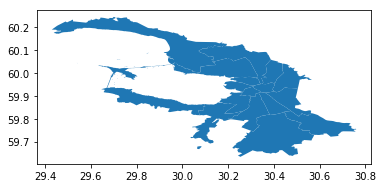

In [59]:
distr_map = gpd.read_file('exportsh/SPb/Saint Petersburg_AL5.shp', encoding="utf-8")
distr_map.plot()

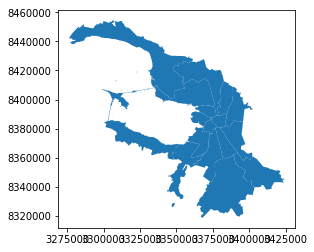

In [60]:
crs = {"init": "epsg:3857"}
distr_map_ep = distr_map.to_crs(crs)
distr_map_ep.plot()

In [61]:
points = [Point(xy) for xy in zip(flats_df.latitude.astype(float), flats_df.longtitude.astype(float))]
crs = {'init' :'epsg:4326'}
flats_geo = GeoDataFrame(flats_df, geometry=points, crs=crs)
flats_geo_ep = flats_geo.to_crs({"init": "epsg:3857"})

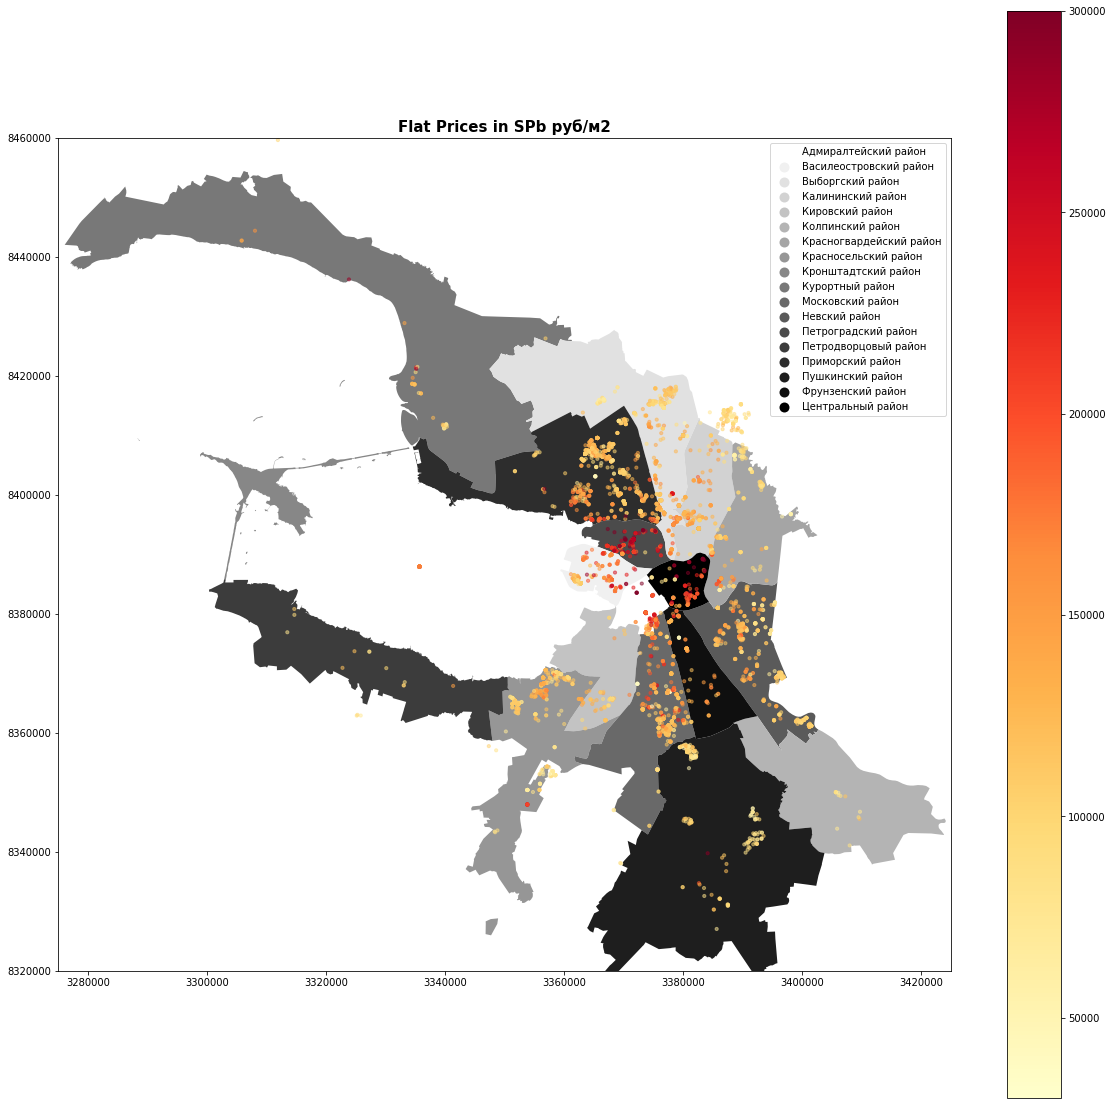

In [62]:
fig, ax = plt.subplots(figsize=(20,20))
distr_map_ep.plot(ax=ax, column = 'locname', linewidth=0.5, cmap='binary', legend=True)
flats_geo_ep.plot(column="price",ax=ax, alpha=0.5, legend=True, markersize=10, cmap="YlOrRd", vmin=30000, vmax=300000)
plt.title("Flat Prices in SPb руб/м2", fontsize=15, fontweight="bold")
plt.ylim(8320000,8460000)
plt.xlim( 3275000,3425000)
plt.show()

In [63]:
flats_geo.head()

,address,area,price,longtitude,latitude,geometry
0,"Санкт-Петербург, ул. Вадима Шефнера, 10к1",65.0,192308,59.938658,30.205582,POINT (30.205582 59.938658)
1,"Санкт-Петербург, ул. Салова, д. 61, лит. А",37.0,146723,59.885142,30.368554,POINT (30.368554 59.885142)
2,"Санкт-Петербург, ул. Плесецкая, д. 20, корп. 1",24.3,127572,60.039076,30.227959,POINT (30.227959 60.039076)
3,"Санкт-Петербург, Пулковское ш., 38к7",26.8,166045,59.820553,30.327591,POINT (30.327591 59.820553)
4,"Санкт-Петербург, ул. Вадима Шефнера, д. 4",28.0,127709,59.934695,30.208681,POINT (30.208681 59.934695)


In [64]:
for i in range(10):
    print(flats_geo.geometry[0].within(distr_map.geometry[i]), i)

False 0
False 1
False 2
False 3
False 4
True 5
False 6
False 7
False 8
False 9


In [50]:
count_price = {}

for point in flats_geo.geometry:
    try:
        for i, geometry in enumerate(distr_map.geometry):
            if point.within(geometry):
                if count_price.get(distr_map.locname[i], None) is None:
                    count_price[distr_map.locname[i]] = [flats_geo.price[i]]
                else:
                    count_price[distr_map.locname[i]].append(flats_geo.price[i])
                flats_geo.drop(flats_geo.index[[i]], inplace=True)
    except KeyError:
        continue

In [67]:
count_price = {}

for j, point in enumerate(flats_geo.geometry):
    for i, geometry in enumerate(distr_map.geometry):
        if point.within(geometry):
            if count_price.get(distr_map.locname[i], None) is None:
                count_price[distr_map.locname[i]] = [flats_geo.price[j]]
            else:
                count_price[distr_map.locname[i]].append(flats_geo.price[j])

In [69]:
from functools import reduce

aver_price = {}
for k, lst in count_price.items():
    aver_price[k] = reduce(lambda a, b: a + b, lst) / len(lst) 
    
aver_price

{'Василеостровский район': 152888.90134529147,
 'Фрунзенский район': 137399.8448275862,
 'Приморский район': 124862.94444444444,
 'Московский район': 133717.4785373609,
 'Пушкинский район': 92259.18918918919,
 'Петроградский район': 242890.4144144144,
 'Красносельский район': 114169.95852534562,
 'Красногвардейский район': 109849.50187265918,
 'Выборгский район': 124685.22933884297,
 'Невский район': 116355.88536155203,
 'Адмиралтейский район': 210600.22522522524,
 'Калининский район': 127073.21794871795,
 'Центральный район': 215795.48529411765,
 'Кировский район': 110041.95652173914,
 'Петродворцовый район': 102117.75,
 'Курортный район': 122612.44736842105,
 'Колпинский район': 87063.26666666666}

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 <a list of 17 Text xticklabel objects>)

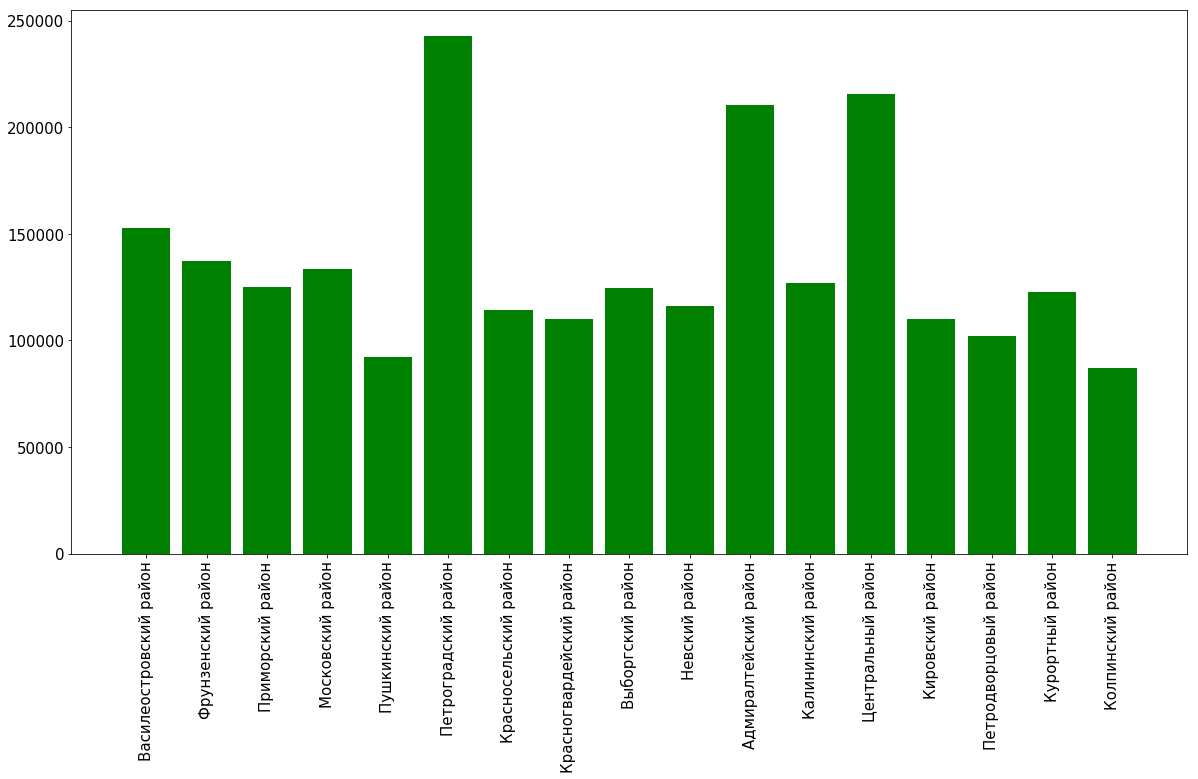

In [70]:
plt.figure(figsize=(20,10))
plt.bar(aver_price.keys(), aver_price.values(), color='g')
plt.tick_params(labelsize=15)
plt.xticks(rotation=90)

In [71]:
#  Визуализация по средней площади квартиры

In [73]:
count_area = {}

for j, point in enumerate(flats_geo.geometry):    
    for i, geometry in enumerate(distr_map.geometry):
        if point.within(geometry):
            if count_area.get(distr_map.locname[i], None) is None:
                count_area[distr_map.locname[i]] = [flats_geo["area"][j]]
            else:
                count_area[distr_map.locname[i]].append(flats_geo["area"][j])

In [74]:
aver_area = {}

for k, lst in count_area.items():
    aver_area[k] = reduce(lambda a, b: a + b, lst) / len(lst) 
    
aver_area

{'Василеостровский район': 62.02286995515696,
 'Фрунзенский район': 51.12500000000001,
 'Приморский район': 47.54553734061931,
 'Московский район': 55.18680445151029,
 'Пушкинский район': 51.76324324324324,
 'Петроградский район': 107.35090090090091,
 'Красносельский район': 53.679953917050724,
 'Красногвардейский район': 51.053183520599276,
 'Выборгский район': 57.98760330578514,
 'Невский район': 46.5095238095238,
 'Адмиралтейский район': 76.83873873873873,
 'Калининский район': 51.03675213675215,
 'Центральный район': 83.07647058823531,
 'Кировский район': 47.01739130434783,
 'Петродворцовый район': 74.45833333333333,
 'Курортный район': 79.6657894736842,
 'Колпинский район': 45.00000000000001}

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 <a list of 17 Text xticklabel objects>)

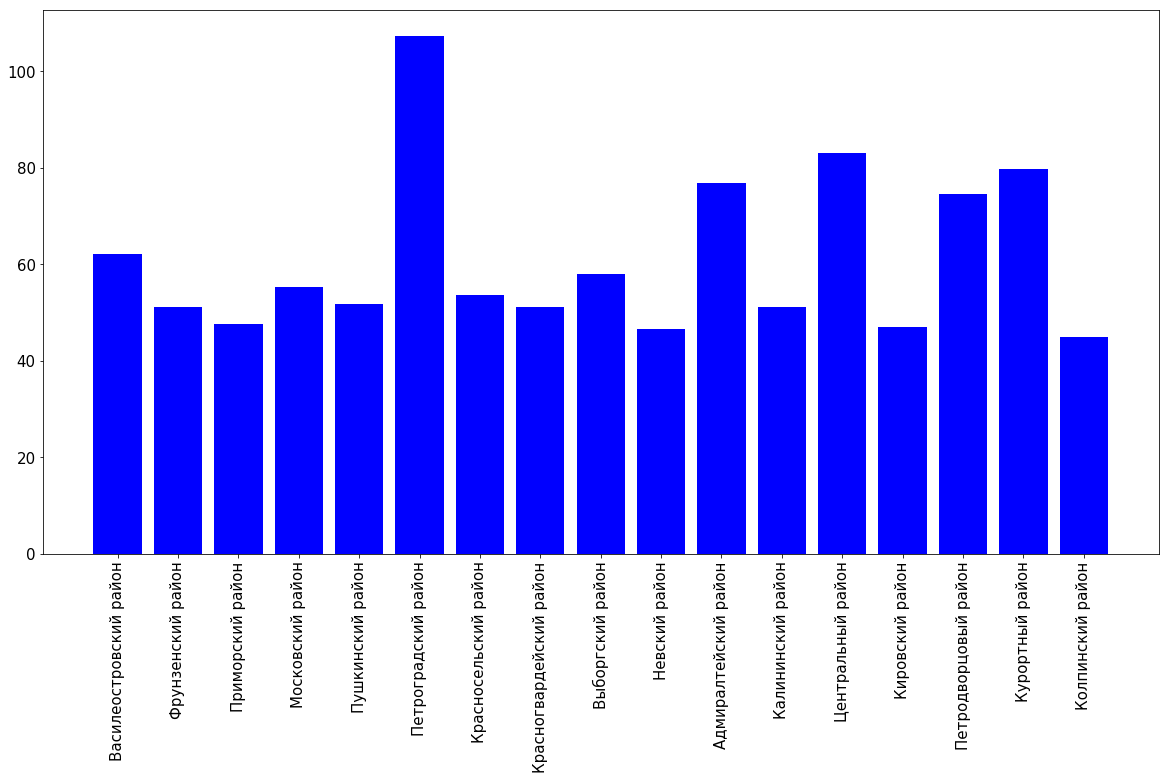

In [75]:
plt.figure(figsize=(20,10))
plt.bar(aver_area.keys(), aver_area.values(), color='b')
plt.tick_params(labelsize=15)
plt.xticks(rotation=90)

In [16]:
# Визуализация с помощью folium

In [17]:
import folium
from folium import plugins
from folium.plugins import HeatMap
from folium.plugins import MarkerCluster

In [18]:
def data_unq(df):
    l_addr = len(df.address.unique())
    l_lon = len(df.longtitude.unique())
    l_lat = len(df.latitude.unique())
    l_price = len(df.price.unique())
    print(f"l_addr: {l_addr}, l_lon: {l_lon}, l_lat: {l_lat}, l_price: {l_price}")

data_unq(flats_df)

l_addr: 2050, l_lon: 1388, l_lat: 1389, l_price: 4326


In [19]:
max_price = float(flats_df.price.max())
min_price = float(flats_df.price.min())
max_price, min_price

(812923.0, 28209.0)

In [20]:
location = [59.960183, 30.345809]
mymap = folium.Map(location=location, zoom_start=10)
mc = MarkerCluster()
lon, lat = 'longtitude', 'latitude'
price, address = "price", "address"

for _, row in flats_df.iterrows():
    info = f"Адрес: {row[address]}, Стоимость:{row[price]} руб/м2"
    mc.add_child(folium.Marker(location=[row[lon], row[lat]], popup=info))
    mymap.add_child(mc)
#mymap

In [21]:
lon = flats_df.longtitude.values.astype(float)
lat = flats_df.latitude.values.astype(float)
price = flats_df.price.values.astype(float)
lat, lon, price
l_data = list(zip(lon, lat, price))
#l_data

In [22]:
hmap = HeatMap(l_data, min_opacity=0.2, max_val=max(price), radius=10, blur=10, max_zoom=1,)
hmap.add_to(mymap)
#mymap

In [23]:
import os
mymap.save(os.path.join('SPb/', 'heatmap.html'))